## TP Neural Networks - Louis Hémadou

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework)

## 0. A simple MLP implementation

As always some useful imports:

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

import scipy.io as sio
# usefull for loading mat files

import scipy.optimize as optimize
# usefull for optimization

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

import gzip
#import cPickle # -> for python2
import pickle  # -> for python3
import os
import os.path
from six.moves import urllib

We will consider a Neural Network as a modular architecture, all layer and loss being a Module. We define the Linear, ReLU layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the least square loss function, LeastSquareCriterion.

In [2]:
import math
import numpy as np

class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensionnal array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self,lr,lamb):
        self.weight=(1-lamb)*self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    
        

class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr,lamb):
        self.fc2.gradientStep(lr,lamb)
        self.fc1.gradientStep(lr,lamb)
        return True

## 1. Training a neural network

To train a network, we will need data. Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). I consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. For this TP, you can focus on the training and validation sets.

5


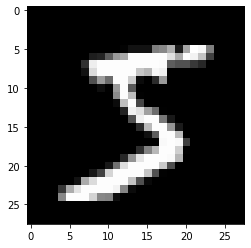

In [3]:
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, val_set, test_set = pickle.load(f, encoding='latin1') # python 3
# train_set, val_set, test_set = cPickle.load(f) # python 2
f.close()
train_data=train_set[0]
train_labels=train_set[1]
val_data=val_set[0]
val_labels=val_set[1]
N_train=train_data.shape[0]
N_val=val_data.shape[0]
# check data makes sense
plt.imshow(train_data[0,:].reshape(28,28))
print(train_labels[0])

In [4]:
def gen_batchs(data, labels, batch_size):
    """Créé des batchs de taille batch_size
    de data et labels"""
    assert(len(data) == len(labels))
    r = np.random.permutation(len(data))
    rdata = data[r[:]]
    rlabels = labels[r[:]]
    for i in range(0, len(data), batch_size):
        yield rdata[i:i+batch_size], rlabels[i:i+batch_size]

def verify_bool(Y, Y_pred):
    """ Retourne le pourcentage de bonnes
    prédictions de Y_pred par rapport
    à Y"""
    assert(len(Y) == len(Y_pred))
    n = len(Y)
    good = 0
    for i in range(n):
        if Y[i] == Y_pred[i]:
            good += 1
    return 100*good/n 

def train(net, loss_net, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = False):
    """Entraine le RN net avec la loss loss_net"""
    loss_values_train = []
    loss_values_val = []
    n_train = len(train_data)
    n_val = len(val_data)
    for k in range(epochs):
        print('training, iteration: '+str(k+1)+'/'+str(epochs)+'\r', sep=' ', end='', flush=True)
        batchs = gen_batchs(train_data, train_labels, batch_size) # Création des batchs pour l'epoch k
        for batch_data in batchs:
            batch = batch_data[0]
            batch_labels = batch_data[1]
            gradInput = loss_net.backward(net.forward(batch), batch_labels)
            net.backward(batch, gradInput)
            net.gradientStep(lr, lamb)
        if Visual: # Calcul de l'erreur quadratique moyenne pour les données d'entrainement et de validation
            loss_values_train.append((1/n_train)*loss_net.forward(net.forward(train_data), train_labels))
            loss_values_val.append((1/n_val)*loss_net.forward(net.forward(val_data), val_labels))
            
    if Visual:
        it = range(len(loss_values_train))
        plt.figure()
        plt.plot(it, loss_values_train, 'r', label = "Training loss")
        plt.plot(it, loss_values_val, 'b', label = "Validation loss")
        plt.legend()
        plt.title("Loss over epochs")
        plt.show()

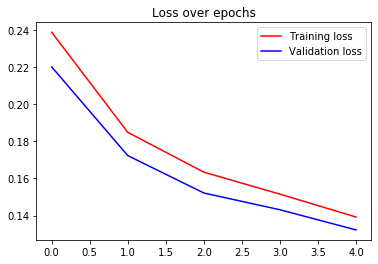

95.24 % validation accuracy


In [5]:
# Paramètres stipulés dans la question 1

mlp = MLP()
loss_mlp = LeastSquareCriterion()
lr = 0.001
lamb = 0
epochs = 5
batch_size= 16
train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = True)
preds = mlp.forward(val_data)
pred_class = [np.argmax(pred) for pred in preds]
print(str(verify_bool(val_labels, pred_class)) + " % validation accuracy")

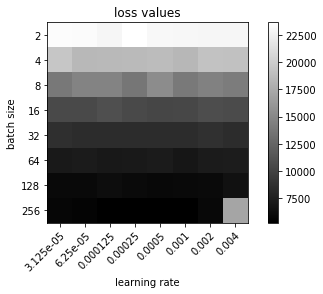

Best learning rate: 0.000125
Best batch size: 256


In [6]:
# Procédure pour trouver les meilleurs hyperparamètres

m = 4
LRATE_VALUES = [lr * 2**(n-1) for n in range(-m, m)] # Echantillonage de plusieurs taux d'apprentissage
BSIZE_VALUES = [int(batch_size * 2**(n+1)) for n in range(-m, m)] # Echantillonage de plusieurs tailles de batch

LOSS_GRID = np.zeros((2*m, 2*m))

epochs = 5
lamb = 0
for i in range(2*m):
    for j in range(2*m):
        lrv = LRATE_VALUES[i]
        bsv = BSIZE_VALUES[j]
        mlp = MLP()
        loss_mlp = LeastSquareCriterion()
        train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, bsv, lrv, lamb, Visual = False)
        preds = mlp.forward(val_data)
        pred_class = [np.argmax(pred) for pred in preds]
        LOSS_GRID[i,j] = loss_mlp.forward(mlp.forward(train_data), train_labels)

fig, ax = plt.subplots()
im = ax.imshow(LOSS_GRID)

ax.set_xticks(np.arange(len(LRATE_VALUES)))
ax.set_yticks(np.arange(len(BSIZE_VALUES)))

ax.set_xticklabels(LRATE_VALUES)
ax.set_yticklabels(BSIZE_VALUES)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("loss values")
fig.tight_layout()
plt.xlabel("learning rate")
plt.ylabel("batch size")
ax.figure.colorbar(im, ax=ax)
plt.show()

j_opt, i_opt = np.unravel_index(np.argmin(LOSS_GRID, axis=None), LOSS_GRID.shape)
lr_opt = LRATE_VALUES[i_opt]
bs_opt = BSIZE_VALUES[j_opt]

print("Best learning rate: " + str(lr_opt))
print("Best batch size: " + str(bs_opt))

In [7]:
number = (784+1)*64 + (64+1)*10
print("Il y a " + str(number) + " paramètres dans le réseau")

Il y a 50890 paramètres dans le réseau


In [8]:
class MLP_2(Module):
    """On donne en entrée une liste de tailles
    de couches intermédiaires souhaitées."""
    def __init__(self, layers, num_classes=10):
        super(MLP_2, self).__init__()
        self.n_layers = len(layers)
        print(str(self.n_layers) + " couche(s) cachée(s)")
        
        if self.n_layers == 0:
            self.fc = [Linear(784, 10)]
        else:
            self.fc = [Linear(784, layers[0])] # Première couche
            for i in range(self.n_layers-1): # Couches cachées
                self.fc.append(Linear(layers[i], layers[i+1]))
            self.fc.append(Linear(layers[-1], 10)) # Dernière couche
            
        self.n_fc = len(self.fc)
        self.relu = [ReLU() for _ in range(self.n_fc-1)]
        
    def forward(self, x):
        for i in range(self.n_fc-1):
            x = self.fc[i].forward(x)
            x = self.relu[i].forward(x)
        x = self.fc[-1].forward(x)
        return x
    
    def backward(self, x, gradient):
        for i in range(self.n_fc-1, 0, -1):
            gradient = self.fc[i].backward(self.relu[i-1].output, gradient)
            gradient = self.relu[i-1].backward(self.fc[i-1].output, gradient)
        gradient = self.fc[0].backward(x, gradient)
        return gradient
    
    def gradientStep(self,lr,lamb):
        for i in range(self.n_fc-1, -1, -1):
            self.fc[i].gradientStep(lr,lamb) 
        return True
    
    def NbParameters(self):
        Nb = sum((self.fc[i].in_features + 1)*self.fc[i].out_features for i in range(self.n_fc))
        print(str(Nb) + " paramètres")

In [9]:
layers = [64, 64, 64, 64, 64]
lamb = 0
for i in range(6):
    mlp = MLP_2(layers[0:i])
    mlp.NbParameters()
    loss_mlp = LeastSquareCriterion()
    lr = 0.001
    epochs = 10
    batch_size = 32
    train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = False)
    preds = mlp.forward(val_data)
    pred_class = [np.argmax(pred) for pred in preds]
    print(str(verify_bool(val_labels, pred_class)) + " % validation accuracy")

0 couche(s) cachée(s)
7850 paramètres
86.29 % validation accuracy
1 couche(s) cachée(s)
50890 paramètres
96.49 % validation accuracy
2 couche(s) cachée(s)
55050 paramètres
96.74 % validation accuracy
3 couche(s) cachée(s)
59210 paramètres
95.38 % validation accuracy
4 couche(s) cachée(s)
63370 paramètres
10.9 % validation accuracy
5 couche(s) cachée(s)
67530 paramètres
10.09 % validation accuracy


Un grand nombre de couches intermédiaires n'est pas gage de précision. Je n'ai pas trouvé d'hyperparamètres pour entrainer convenablement les RN avec 4 et 5 couches cachées.

4 couche(s) cachée(s)
50990 paramètres


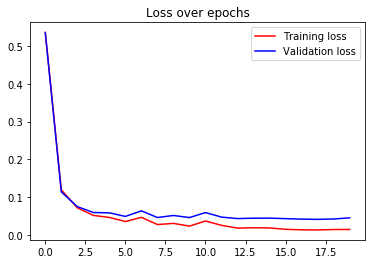

97.26 % validation accuracy


In [13]:
# Un exemple de réseau avec un nombre de paramètres semblables au premier réseau

layers = [60, 40, 20, 20]
mlp = MLP_2(layers)
mlp.NbParameters()
loss_mlp = LeastSquareCriterion()
lr = 0.01
lamb = 0
epochs = 20
batch_size = 32
train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = True)
preds = mlp.forward(val_data)
pred_class = [np.argmax(pred) for pred in preds]
print(str(verify_bool(val_labels, pred_class)) + " % validation accuracy")

Malgré le fait que ce réseau ait plus de couches que le réseau initial, on observe une précision plus semblable au réseau unitial, qui comporte une unique couche cachée. Cela pourrait s'expliquer en partie par le fait que ces deux réseaux ont un nombre de paramètres semblables.

3 couche(s) cachée(s)
59210 paramètres


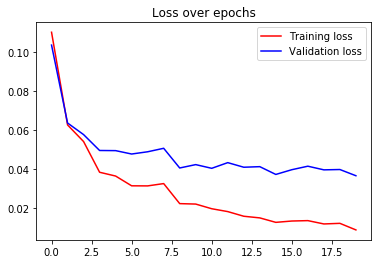

97.84 % validation accuracy
99.626 % training accuracy


In [11]:
# Surapprentissage sans régularisation

layers = [64, 64, 64]
mlp = MLP_2(layers)
mlp.NbParameters()
loss_mlp = LeastSquareCriterion()
lr = 0.02
lamb = 0
epochs = 20
batch_size = 32
train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = True)
preds_val = mlp.forward(val_data)
preds_train = mlp.forward(train_data)
pred_class_val = [np.argmax(pred) for pred in preds_val]
pred_class_train = [np.argmax(pred) for pred in preds_train]

print(str(verify_bool(val_labels, pred_class_val)) + " % validation accuracy")
print(str(verify_bool(train_labels, pred_class_train)) + " % training accuracy")

On observe ici du surapprentissage. En effet, la validation loss ne suit plus la training loss à partir d'une certaine epoch.

3 couche(s) cachée(s)
59210 paramètres


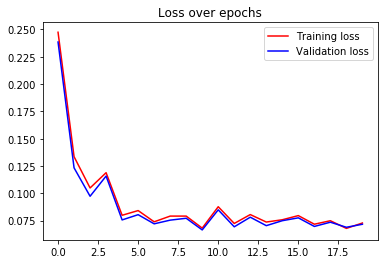

96.26 % validation accuracy
96.28 % training accuracy


In [12]:
# Surapprentissage avec régularisation

layers = [64, 64, 64]
mlp = MLP_2(layers)
mlp.NbParameters()
loss_mlp = LeastSquareCriterion()
lr = 0.02
lamb = 0.001
epochs = 20
batch_size = 32
train(mlp, loss_mlp, train_data, val_data, train_labels, val_labels, epochs, batch_size, lr, lamb, Visual = True)
preds_val = mlp.forward(val_data)
preds_train = mlp.forward(train_data)
pred_class_val = [np.argmax(pred) for pred in preds_val]
pred_class_train = [np.argmax(pred) for pred in preds_train]

print(str(verify_bool(val_labels, pred_class_val)) + " % validation accuracy")
print(str(verify_bool(train_labels, pred_class_train)) + " % training accuracy")

Ici, uniquement le paramètre de régularisation a été modifié. On voit que la précision des prédictions du réseau sur les deux ensembles est quasiment identiques, on a réduit le surapprentissage. Cette réduction du surapprentissage est néanmoins au prix d'une précision moindre.

0/ Read and understand the code provided above

1/ Write a simple loop to train 50 iterations of the MLP defined in 0 with a learning rate 0.001 and batches of size 16.

2/ Evaluate the resulting model on the training and validation data. Check visually the quality of the results.

3/ Plot the training and validation losses and accuracies during the training of question 1. (note: you don't have to test your network at every iteration, you can for example do it every 10 iterations)

4/ Design a training procedure that optimize the training loss (decide for a learning rate, batch size...)

## 2. Overfitting

1/ What's the number of parameters in the network of 1?

2/ Design a new network with 3 layer, the middle one having 64 dimensions.What is it number of parameters? What can be said about their comparative performances? Test networks with a growing number of such intermediate layers up to 5 and analyze their performances.

3/ Add a parameter to vary the size of the intermediate layers. Design networks with varying number of layers as in the previous question, while having the same number of total parameters as the network of 1. What can be said about their comparative performances?

4/ Keeping the training procedure fixed, test different size of networks and layers. Show evidence of overfitting.

4/ Add an optionnal parameter for weight decay (in the gradientStep functions) and show that it can reduce overfitting in some cases (improving the validation performance may be hard, you would have to look at a setting with very little training data to see, you can focus on showing that the gap between training and validation performance decreases)

## 3. Optionnal

The following questions are optionnal and do not have a specific order! 

1/ Add some momentum to your training procedure. How does it change the training behavior?

2/ Implement and test different loss functions (L1, Cross-Entropy)

3/ Implement and test different non-linearities

4/ (longer/harder) Implement and test layers that consider the 2D structure of the input data (max pooling, convolution)